In [1]:
from __future__ import division

import sys
import os
from math import pi

import numpy as np
import pandas as pd

from collections import Counter
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.5)

In [2]:
# =======
# FOLDERS
# =======
package_path = os.path.dirname(os.getcwd())
data_path = os.path.join(package_path, 'data')

In [3]:
# =========
# LOAD DATA
# =========
input_file = os.path.join(data_path, 'train.json')

df = pd.read_json(input_file)

# First look at the dataset

In [4]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


The dataset looks pretty organized in a first view. All the ingredients of each recipe are entries of a list, but we still don't know if we can encounter typos or special characters between them.

# Recipes

Let's have an idea of the size of the dataset looking at how many recipes it has.

In [5]:
n_recipes = df.shape[0]
print('This dataset has %i recipes.' % n_recipes)

This dataset has 39774 recipes.


# Cuisines

Now, let's check what cuisines are present in the dataset.

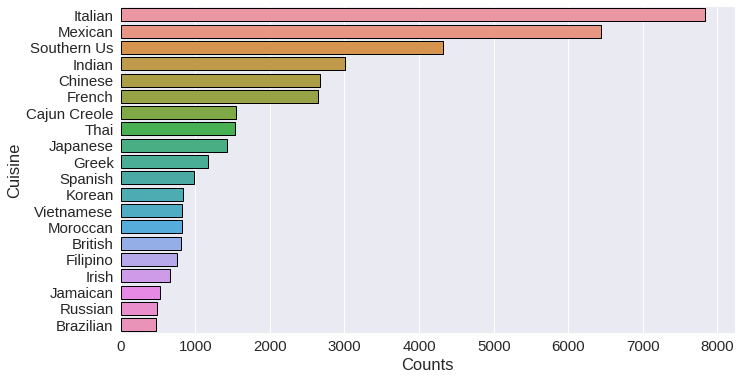

In [6]:
cuisine = df['cuisine'].value_counts()
cuisine_names = list(cuisine.index)
cuisine_values = list(cuisine.values)

# string manipulation of cuisine names
for i, name in enumerate(cuisine_names):
    capital_name = name.title() # capitalize each word
    cuisine_names[i] = capital_name
    
    if capital_name.find('_') > 0: # found an underscore in the string name
        clean_name = capital_name.replace('_', ' ') # replace it with a space
        cuisine_names[i] = clean_name

plt.figure(figsize=(11, 6))
sns.barplot(x=cuisine_values, y=cuisine_names, edgecolor=(0,0,0), linewidth=1)
plt.ylabel('Cuisine')
plt.xlabel('Counts')
plt.show()

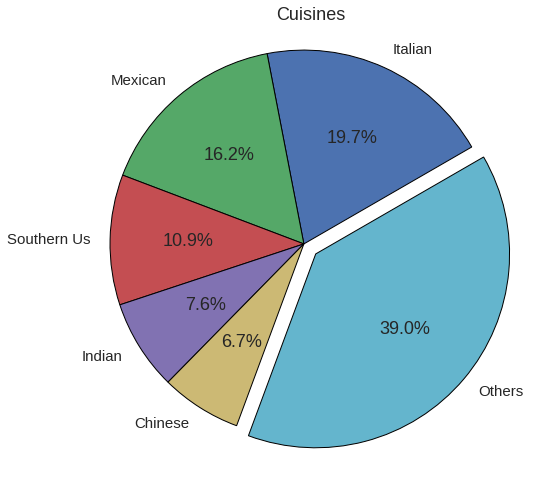

In [7]:
top_cuisines = 5
short_cuisine_values = cuisine_values[0:top_cuisines]
short_cuisine_values.append(sum(cuisine_values[top_cuisines:]))
short_cuisine_names = cuisine_names[0:top_cuisines]
short_cuisine_names.append(u'Others')

# making a pie plot
plt.figure(figsize=(7,7))

# explode the last slice ('Others')
explode = list(np.zeros(top_cuisines))
explode.append(0.08)

# edges properties
wedgeprops={"edgecolor":"k", 'linewidth': 1}

plt.pie(short_cuisine_values, labels=short_cuisine_names, startangle=30,  
        autopct='%1.1f%%', explode=explode, wedgeprops=wedgeprops)
plt.title('Cuisines')
plt.tight_layout()
plt.axis('equal')
plt.show()

In [8]:
n_cuisines = cuisine.nunique()
print('This dataset has %i different cuisines.' % n_cuisines)

This dataset has 20 different cuisines.


As we can see in the previous plots, **Italian** and **Mexican** cuisines have the biggest statistics of the entire dataset. So, we will have to keep in mind that this effect could introduce a bias in our learning model. In other words, our dataset does not have balanced classes.

# Ingredients 

We can also check the average amount of ingredients by each cuisine.

In [9]:
# adding a new column with the amount of ingredients for each recipe
df['n_ingredients'] = df['ingredients'].str.len()
df.head()

,cuisine,id,ingredients,n_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20


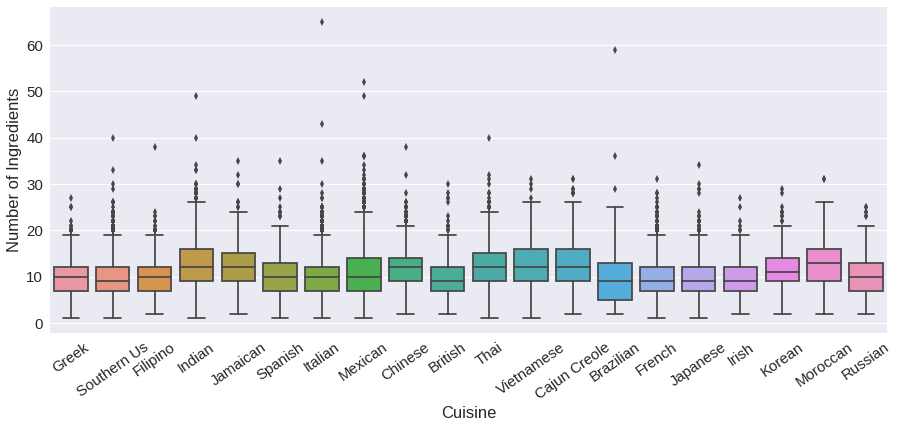

In [10]:
plt.figure(figsize=(15,6))

# string manipulation of cuisine names
cuisine_names = []

for name in df.cuisine.unique():
    name = name.title() # capitalize each word
    
    if name.find('_') > 0: # found an underscore in the string name
        name = name.replace('_', ' ') # replace it with a space
    cuisine_names.append(name)


ax = sns.boxplot(x='cuisine', y='n_ingredients', data=df)
plt.ylabel('Number of Ingredients')
plt.xlabel('Cuisine')
plt.xticks(plt.xticks()[0], cuisine_names)
ax.set_xticklabels(ax.get_xticklabels(),rotation=35)
plt.show()

It looks like every cuisine has on average the same amount of ingredients within the error bars. There is no big discrepancy among them.

Now let's have a look on the most used ingredients in the total dataset.

In [11]:
def parallel_counting(data):
    """
    Auxiliary function for parallel counting.
    """
    return data.map(Counter).sum()

def ingredients_counter(data):
    """
    Function to count the ingredients in parallel fashion.
    
    Parameter:
    ---------
    data : pandas series
        Pandas Series object with the ingredients for counting.
        
    Returns:
    -------
    ingredients_count : pandas series
        Series with count for each ingredient.
        
    Note:
    ----
    The ingredients are returned in descending order
    """
    # Let's make this counter process parallel 
    # using the 'multiprocessing' library
    cores = cpu_count()

    # separate data into chunks for the parallel processing
    data_chunks = np.array_split(data, cores)
    
    pool = Pool(cores)
    counter_list = pool.map(parallel_counting, data_chunks)
    pool.close()

    ingredients_count = pd.Series(sum(counter_list, Counter())).sort_values(ascending=False)
    return ingredients_count

The process of counting can be very time consuming, so to overcome this issue we will count the number of ingredients in a parallel way.

In [12]:
%%time
# Counting ingredients from the entire dataset
ingredients_count = ingredients_counter(df['ingredients'])

CPU times: user 764 ms, sys: 120 ms, total: 884 ms
Wall time: 1min 10s


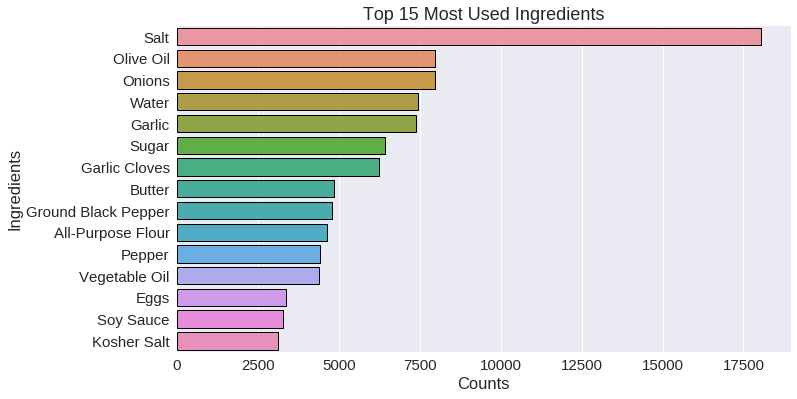

In [13]:
# Getting the top ingredients in the whole dataset
top_common = 15
top_ingredients_names = list(ingredients_count[:top_common].index)
top_ingredients_values = list(ingredients_count[:top_common].values)

# string manipulation of cuisine names
clean_names = []
for i, name in enumerate(top_ingredients_names):
    name = name.title() # capitalize each word
    
    if name.find('_') > 0: # found an underscore in the string name
        name = name.replace('_', ' ') # replace it with a space
    clean_names.append(name)

plt.figure(figsize=(11,6))
sns.barplot(x=top_ingredients_values, y=clean_names, edgecolor=(0,0,0), linewidth=1)
plt.ylabel('Ingredients')
plt.xlabel('Counts')
plt.title('Top %i Most Used Ingredients' % int(top_common))
plt.show()

Looking at the bar plot above, we can spot some ambiguous ingredients like:

* Salt - Kosher Salt
* Garlic - Garlic Cloves
* Ground Black Pepper - Pepper

This could be a problem when we comme up with a representation method for each ingredient, before feeding it to the classification model.

## Comparing ingredients of different cuisines

In this section we will make a **Radar Plot** to compare how much the **Italian** and **Mexican** cuisines use the top ingredients of the entire dataset.

In [14]:
def cuisine_ingredients(data_frame, cuisine_name):
    """
    This function gets the specific ingredients for a particular cuisine.
    
    Parameters:
    ----------
    data_frame : pandas dataframe
        The original dataset.
    cuisine_name : str
        Cuisine name as written in the original dataset.
            - mexican
            - italian
            - cajun_creole ...
            
    Returns:
    -------
    data : pandas series
        Pandas Series with the ingredients for the specific cuisine.
    """
    data = data_frame['ingredients'][data_frame['cuisine']==cuisine_name]
    return pd.Series(data)

In [15]:
def ingredients_radar_plot(data1, data2, cuisine_names, ingredients_names):
    """
    Function to create and plot a radar graph comparing
    ingredients of two different cuisines.
    
    Parameters:
    ----------
    data1 : pandas series
        Series with the ingredients of the first cuisine.
    data2 : pandas series
        Series with the ingredients of the second cuisine.
    cuisine_names : list
        List containing the names of each cuisine for comparison.
    ingredients_names : list
        List containing the names of the ingredients that one 
        would like to compare.
        
    Returns:
    -------
    Radar Plot on Screen.
    
    Note:
    ----
    The quantity of ingredients is normalized 
    """
    # string manipulation of cuisine names
    clean_names = []
    for i, name in enumerate(ingredients_names):
        name = name.title() # capitalize each word
    
        if name.find('_') > 0: # found an underscore in the string name
            name = name.replace('_', ' ') # replace it with a space
        clean_names.append(name)
    
    # PART 1: Create Background
    N = len(ingredients_names)
    
    # What will be the angle of each axis in the plot? 
    # R: plot / number of variables.
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles.append(angles[0]) # We need to repeat the first values 
                             # to close the circular graph
        
    # Initialise the spider plot
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable + add labels yet
    plt.xticks(angles[:-1], clean_names)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(color="grey", size=13)
    
    # PART 2: Add plots
    # Ind1
    values = list(data1[ingredients_names] / sum(data1[ingredients_names]))
    values.append(values[0])
    ax.plot(angles, values, linewidth=1, linestyle='solid', 
            label=cuisine_names[0], color='b')
    ax.fill(angles, values, 'b', alpha=0.1)
 
    # Ind2
    values = list(data2[ingredients_names] / sum(data2[ingredients_names]))
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', 
            label=cuisine_names[1], color='r')
    ax.fill(angles, values, 'r', alpha=0.1)
 
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
    plt.show()

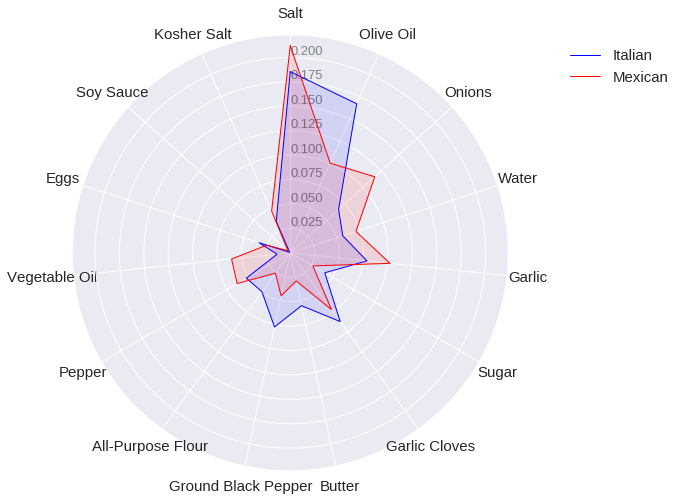

In [16]:
# Selecting ingredients from two different cuisines
cuisine_names = ['Italian', 'Mexican']

cuisine1_ingredients = cuisine_ingredients(df, cuisine_names[0].lower())
cuisine2_ingredients = cuisine_ingredients(df, cuisine_names[1].lower())

# Counting ingredients from Mexican and Italian cuisines
cuisine1_ingredients_count = ingredients_counter(cuisine1_ingredients)
cuisine2_ingredients_count = ingredients_counter(cuisine2_ingredients)

ingredients_radar_plot(cuisine1_ingredients_count, cuisine2_ingredients_count, 
                       cuisine_names, top_ingredients_names)

## Summary

* The dataset is unbalanced.
* The average number of ingredients is approximately the same for each cuisine.
* There are some ingredients with ambiguous names.